In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import glob
import os
from skimage.transform import resize

In [2]:
def imlist_toarray(imlist):
    imarray = []
    for i in range(len(imlist)):
        array = plt.imread(imlist[i])
        array = resize(array,(224,224),anti_aliasing=True)
        imarray.append(array)
    return np.array(imarray)



In [3]:
dir = "/home/akinyilmaz/Desktop/Jupyter_Lab/all/"
train = "train/"
test = "test/"

dog_train_images = glob.glob(dir+train+"dog/"+"*.jpg")
dog_test_images = glob.glob(dir+test+"dog/"+"*.jpg")

cat_train_images = glob.glob(dir+train+"cat/"+"*.jpg")
cat_test_images = glob.glob(dir+test+"cat/"+"*.jpg")

dog_train = imlist_toarray(dog_train_images)
cat_train = imlist_toarray(cat_train_images)
dog_test = imlist_toarray(dog_test_images)
cat_test = imlist_toarray(cat_test_images)

X_train = np.concatenate((dog_train,cat_train),axis=0)
Y_train = np.concatenate((np.zeros(shape=(dog_train.shape[0])),np.ones(shape=(cat_train.shape[0]))))
X_test = np.concatenate((dog_test,cat_test),axis=0)
Y_test = np.concatenate((np.zeros(shape=(dog_test.shape[0])),np.ones(shape=(cat_test.shape[0]))))
X_train.shape,X_test.shape

/home/akinyilmaz/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


((400, 224, 224, 3), (200, 224, 224, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


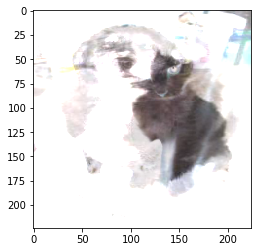

In [4]:
#plt.imshow(X_test[199,:,:,:])
diff = X_test[199,:,:,:] - X_test[19,:,:,:]
plt.imshow(1- diff)

In [18]:
model_vgg = models.vgg16(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(in_features=4096, out_features=4096, bias=True),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(in_features=4096, out_features=1, bias=True),
                                    nn.Sigmoid())

for param in model_vgg.classifier.parameters():
    param.requires_grad = True

def add_layer(model,typ,index,sub_typ):
    lis_of_


In [6]:
def preconvfeat(X,Y):
    conv_features = []
    labels_list = []
    im_number = len(Y)
    print(im_number)
    for k in range(im_number):
        inputs,labels = X[k,:,:,:].reshape(1,X.shape[3],X.shape[1],X.shape[2]), Y[k]
        
        inputs , labels = torch.from_numpy(inputs).float(),torch.tensor(labels).float()
        x = model_vgg.features(inputs)
        conv_features.extend(x.numpy())
        labels_list.append(labels.data)

    conv_features = np.concatenate([[feat] for feat in conv_features])
    return conv_features,np.array(labels_list)

In [7]:
conv_feat_train,labels_train = preconvfeat(X_train,Y_train)

400


In [ ]:
conv_feat_test,labels_test = preconvfeat(X_test,Y_test)

In [ ]:
conv_feat_test.shape,labels_test.shape

In [9]:
def calculate_loss(out,Y):
    loss = torch.mean(torch.sum(-Y*torch.log(out)))
    return loss
optimizer = optim.Adam(model_vgg.classifier[6].parameters(),lr = 5.e-3)
#criterion = nn.CrossEntropyLoss()
#lr = 5.e-3
#optimizer = optim.Adam(model_vgg.classifier[6].parameters(),lr = lr)

In [10]:
def data_gen(conv_feat,labels,batch_size,shuffle=True):
    if shuffle:
        index = np.random.permutation(len(labels))
        conv_feat = conv_feat[index,:,:,:]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])


In [19]:
def train_model(model,optimizer,batch_size,conv_feat,labels,nb_epoch,shuffle):
    size = labels.shape[0]
    for epoch in range(1,nb_epoch+1):
        batches = data_gen(conv_feat=conv_feat,labels=labels,batch_size=batch_size,shuffle=shuffle)
        running_loss = 0.0
        running_corrects = 0.0
        for inputs,classes in batches:
            inputs , classes = torch.from_numpy(inputs).float(), torch.from_numpy(classes).float()
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            
            
            loss = calculate_loss(outputs,classes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print(outputs)
            running_loss += loss.data[0]
            #outputs[outputs >= 0.5] = 1.0
            #outputs[outputs < 0.5] = 0.0
            running_corrects += torch.sum(classes == outputs.view(-1)).data[0]
        print(classes)
        print(outputs.view(-1))            
        print("epoch: "+str(epoch))
        print("loss: "+str(running_loss/size))
        print("accuracy: "+str(running_corrects.item()/size))

            

In [20]:
train_model(model=model_vgg.classifier,conv_feat=conv_feat_train,labels=labels_train,nb_epoch=50,optimizer=optimizer,shuffle=True,batch_size=32)

/home/akinyilmaz/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/akinyilmaz/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.])
tensor([0.5202, 0.5061, 0.4994, 0.5130, 0.4999, 0.4848, 0.5012, 0.4957, 0.4809,
        0.5089, 0.5024, 0.4911, 0.5068, 0.5066, 0.4937, 0.5065],
       grad_fn=<ViewBackward>)
epoch: 1
loss: tensor(10.7189)
accuracy: 0.0
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.])
tensor([0.5127, 0.5032, 0.5070, 0.5133, 0.5057, 0.5118, 0.4751, 0.5057, 0.4999,
        0.5094, 0.5054, 0.5231, 0.5022, 0.5188, 0.4990, 0.5187],
       grad_fn=<ViewBackward>)
epoch: 2
loss: tensor(10.7343)
accuracy: 0.0
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([0.5040, 0.5232, 0.5147, 0.5053, 0.4947, 0.5026, 0.4996, 0.5167, 0.4853,
        0.4924, 0.4981, 0.5194, 0.5106, 0.5215, 0.5325, 0.5215],
       grad_fn=<ViewBackward>)
epoch: 3
loss: tensor(10.8023)
accuracy: 0.0
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([0.5059, 0.5092, 0.5047, 0.5058, 0.509

KeyboardInterrupt: 

In [ ]:
o,y = torch.from_numpy(labels_train[:10]).float(),torch.from_numpy(labels_train[295:305]).float()

o,y


In [ ]:
loss = calculate_loss(out=o,Y=y)
loss